<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/ll2egpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [ ]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [ ]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Usa il checkpoint direttamente da Drive

In [ ]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [ ]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [ ]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


# EEGPT on the true dataset

## ridefiniamo build all usando rec_id

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [ ]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [ ]:
def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    # prende le prime C colonne come EEG
    X = df.iloc[:, :C].to_numpy(dtype=np.float32).T  # (C,T)
    return X

def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X_ct):
    # X_ct: (C,T) -> epochs: (N,C,1024)
    x = X_ct.T  # (T,C)
    x = bandpass(x, fs_in)
    x = notch50(x, fs_in)
    x = detrend(x, axis=0, type='linear')
    x = robust_clip(x, q=0.999)
    x = resample_to(x, fs_in, FS_OUT)  # (T2,C)
    epochs = epoch_signal(x, FS_OUT)   # (N,1024,C)
    if epochs.shape[0]==0:
        return np.empty((0, C, int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    epochs = np.transpose(epochs, (0,2,1))  # (N,C,1024)

    # robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    epochs = (epochs - med) / (1.4826 * mad)
    return epochs.astype(np.float32)


## build_all

In [ ]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:
                    X_ct = load_ct_matrix(path, C=C)
                    epochs = preprocess_recording(X_ct)  # (Nw,C,1024)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([li]*len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (1685, 8, 1024) y_all: (1685,) unique rec: 45


## recording-level

Questo blocco serve a fare cross-validation a livello di registrazione (non di finestra), mantenendo l’indipendenza tra soggetti, e poi usare quei recording per selezionare le finestre giuste

In [ ]:
print("X_all:", X_all.shape)
print("y_all:", y_all.shape, "meta rec:", meta["rec_id"].shape)
print("unique rec:", len(np.unique(meta["rec_id"])))


X_all: (1685, 8, 1024)
y_all: (1685,) meta rec: (1685,)
unique rec: 45


In [ ]:
# Costruisco tabella "recording-level"
rec_ids = np.unique(meta["rec_id"])
rec_to_subject = {rid: rid.split("|")[-1] for rid in rec_ids}  # "...|S7" -> "S7"
rec_subjects = np.array([rec_to_subject[r] for r in rec_ids])

# label per recording: prendo la label della prima finestra di quel rec_id
rec_label = {}
for rid in rec_ids:
    idx = np.where(meta["rec_id"] == rid)[0][0]
    rec_label[rid] = int(y_all[idx])
rec_y = np.array([rec_label[r] for r in rec_ids], dtype=np.int64)

# 5-fold subject-independent sui recording
gkf = GroupKFold(n_splits=5)
folds = []
for trainval_idx, test_idx in gkf.split(rec_ids, rec_y, groups=rec_subjects):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, va_rel = next(gss.split(trainval_idx, groups=rec_subjects[trainval_idx]))
    tr_idx = trainval_idx[tr_rel]
    va_idx = trainval_idx[va_rel]
    folds.append({"train_rec": rec_ids[tr_idx], "val_rec": rec_ids[va_idx], "test_rec": rec_ids[test_idx]})

FOLD = 0
train_rec = set(folds[FOLD]["train_rec"])
val_rec   = set(folds[FOLD]["val_rec"])
test_rec  = set(folds[FOLD]["test_rec"])

print("Fold0 recordings:", len(train_rec), len(val_rec), len(test_rec))


Fold0 recordings: 27 9 9


WindowDataset e i DataLoader fanno solo tre cose:
- selezionano le finestre giuste con la maschera (rec_id ∈ train_rec/val_rec/test_rec)
- tengono in memoria self.X/self.y/self.r
- in __getitem__ trasformano self.X[i] e self.y[i] in tensori torch

In [ ]:
class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        mask = np.array([rid in keep_rec_set for rid in rec_id_all])
        self.X = X_all[mask]               # (N,C,1024)
        self.y = y_all[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        x = torch.tensor(self.X[i], dtype=torch.float32)  # (8,1024)
        y = torch.tensor(self.y[i], dtype=torch.long)
        rid = self.r[i]
        return x, y, rid

BATCH=64
train_ds = WindowDataset(X_all, y_all, meta["rec_id"], train_rec)
val_ds   = WindowDataset(X_all, y_all, meta["rec_id"], val_rec)
test_ds  = WindowDataset(X_all, y_all, meta["rec_id"], test_rec)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)

print("windows:", len(train_ds), len(val_ds), len(test_ds))


windows: 1023 338 324


## definizione modello

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
channels = [c.upper().strip('.') for c in my_channels]

for c in channels:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto: {c}"
print("Channels:", channels)

print("Checkpoint exists:", ckpt_path.exists(), ckpt_path)



Device: cuda
Channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']
Checkpoint exists: True /content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt


In [ ]:
# lista 58 canali nell'ordine corretto (ordinati per indice)
inv = {idx: name for name, idx in CHANNEL_DICT.items()}
print(inv)
channels_58 = []
missing = []
for i in range(58):
    if i in inv:
        channels_58.append(inv[i])
    else:
        missing.append(i)

print("len(channels_58) =", len(channels_58))
print("missing idx:", missing)
print("first 10:", channels_58[:10])


model = EEGPTClassifier(
    num_classes=3,
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=128,
    desired_time_len=1024,
    use_channels_names=channels_58,
    ckpt_path=str(ckpt_path),
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad = False
print("Model ready.")




{0: 'FP1', 1: 'FPZ', 2: 'FP2', 3: 'AF7', 4: 'AF3', 5: 'AF4', 6: 'AF8', 7: 'F7', 8: 'F5', 9: 'F3', 10: 'F1', 11: 'FZ', 12: 'F2', 13: 'F4', 14: 'F6', 15: 'F8', 16: 'FT7', 17: 'FC5', 18: 'FC3', 19: 'FC1', 20: 'FCZ', 21: 'FC2', 22: 'FC4', 23: 'FC6', 24: 'FT8', 25: 'T7', 26: 'C5', 27: 'C3', 28: 'C1', 29: 'CZ', 30: 'C2', 31: 'C4', 32: 'C6', 33: 'T8', 34: 'TP7', 35: 'CP5', 36: 'CP3', 37: 'CP1', 38: 'CPZ', 39: 'CP2', 40: 'CP4', 41: 'CP6', 42: 'TP8', 43: 'P7', 44: 'P5', 45: 'P3', 46: 'P1', 47: 'PZ', 48: 'P2', 49: 'P4', 50: 'P6', 51: 'P8', 52: 'PO7', 53: 'PO5', 54: 'PO3', 55: 'POZ', 56: 'PO4', 57: 'PO6', 58: 'PO8', 59: 'O1', 60: 'OZ', 61: 'O2'}
len(channels_58) = 58
missing idx: []
first 10: ['FP1', 'FPZ', 'FP2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3']
Model ready.


## creazione di canali fittizzi a 0

In [ ]:
# i tuoi 8 canali (devono essere presenti in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_8 = [c.upper().strip('.') for c in my_channels]
chan_ids_8 = [CHANNEL_DICT[c] for c in use_channels_8]
print("chan_ids_8:", chan_ids_8)

def embed_8_to_58(xb_8):
    """
    xb_8: (B,8,1024) -> (B,58,1024) con zero-fill
    """
    B, C8, T = xb_8.shape
    xb_58 = torch.zeros(B, 58, T, device=xb_8.device, dtype=xb_8.dtype)
    xb_58[:, chan_ids_8, :] = xb_8
    return xb_58

@torch.no_grad()
def extract_eegpt_features(loader):
    feats_all, y_all, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()            # (B,8,1024)
        xb58 = embed_8_to_58(xb)              # (B,58,1024)

        feats = model.forward_features(xb58)  # (B,D)
        feats_all.append(feats.cpu())
        y_all.append(yb.cpu())
        rec_all.extend(list(rid))

    return torch.cat(feats_all, 0), torch.cat(y_all, 0), np.array(rec_all)

tr_feat, tr_y, tr_rec = extract_eegpt_features(train_loader)
va_feat, va_y, va_rec = extract_eegpt_features(val_loader)
te_feat, te_y, te_rec = extract_eegpt_features(test_loader)

print("feat shapes:", tr_feat.shape, va_feat.shape, te_feat.shape)

torch.save({
    "tr_feat": tr_feat, "tr_y": tr_y, "tr_rec": tr_rec,
    "va_feat": va_feat, "va_y": va_y, "va_rec": va_rec,
    "te_feat": te_feat, "te_y": te_y, "te_rec": te_rec,
}, "eegpt_window_features_fold0.pt")
print("saved: eegpt_window_features_fold0.pt")


chan_ids_8: [0, 2, 7, 9, 11, 13, 15, 30]
feat shapes: torch.Size([1023, 512]) torch.Size([338, 512]) torch.Size([324, 512])
saved: eegpt_window_features_fold0.pt


## t-sne + confusion matrix

dict_keys(['tr_feat', 'tr_y', 'tr_rec', 'va_feat', 'va_y', 'va_rec', 'te_feat', 'te_y', 'te_rec'])
WINDOW shapes: torch.Size([1023, 512]) torch.Size([338, 512]) torch.Size([324, 512])
unique rec counts: 27 9 9
TSN shapes: torch.Size([27, 512]) torch.Size([9, 512]) torch.Size([9, 512])
num_classes: 3
epoch 001 | loss=1.095 | tr_acc=0.333 | va_acc=0.222 | best_va=0.222
Early stop.

TEST acc: 0.3333333432674408
Confusion matrix:
 [[0 2 1]
 [1 1 1]
 [0 1 2]]

Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.250     0.333     0.286         3
           2      0.500     0.667     0.571         3

    accuracy                          0.333         9
   macro avg      0.250     0.333     0.286         9
weighted avg      0.250     0.333     0.286         9



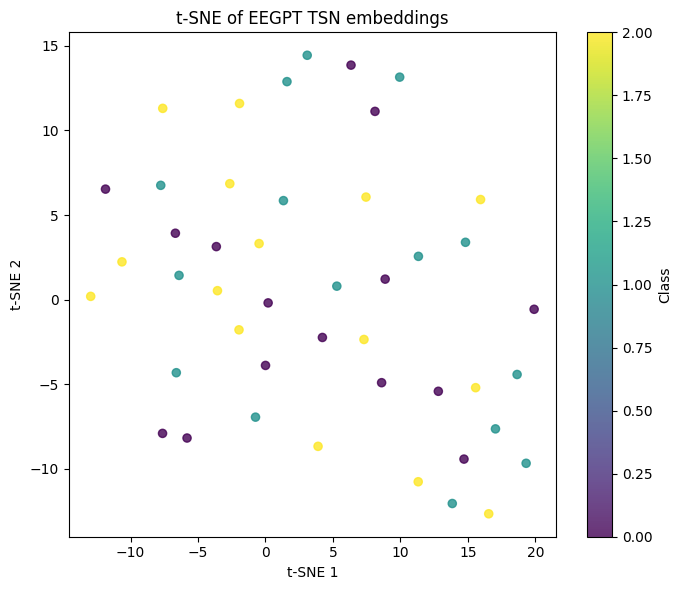

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ========== 1) LOAD WINDOW FEATURES ==========

data = torch.load("eegpt_window_features_fold0.pt", map_location="cpu", weights_only=False)
print(data.keys())


tr_feat = data["tr_feat"]  # torch (Nwin, D)
tr_y    = data["tr_y"]     # torch (Nwin,)
tr_rec  = data["tr_rec"]   # numpy o list

va_feat = data["va_feat"]
va_y    = data["va_y"]
va_rec  = data["va_rec"]

te_feat = data["te_feat"]
te_y    = data["te_y"]
te_rec  = data["te_rec"]

print("WINDOW shapes:", tr_feat.shape, va_feat.shape, te_feat.shape)

# ========== 2) FIX rec_id in modo robusto ==========
def to_numpy_ids(rec):
    # rec può essere numpy array, lista, tensor…
    if isinstance(rec, torch.Tensor):
        rec = rec.cpu().numpy()
    rec = np.asarray(rec)

    # se è dtype=object o stringhe, lo trasformo in codici interi stabili
    if rec.dtype == object or rec.dtype.kind in ("U", "S"):
        uniq, inv = np.unique(rec.astype(str), return_inverse=True)
        return inv.astype(np.int64)
    return rec.astype(np.int64)

tr_rec = to_numpy_ids(tr_rec)
va_rec = to_numpy_ids(va_rec)
te_rec = to_numpy_ids(te_rec)

print("unique rec counts:", len(np.unique(tr_rec)), len(np.unique(va_rec)), len(np.unique(te_rec)))

# ========== 3) TSN pooling (mean) ==========
def tsn_pool(feat, y, rec):
    uniq = np.unique(rec)
    X, Y = [], []
    for rid in uniq:
        m = (rec == rid)
        X.append(feat[m].mean(dim=0))
        Y.append(int(y[m][0].item()))
    return torch.stack(X), torch.tensor(Y, dtype=torch.long)

X_tr, y_tr = tsn_pool(tr_feat, tr_y, tr_rec)
X_va, y_va = tsn_pool(va_feat, va_y, va_rec)
X_te, y_te = tsn_pool(te_feat, te_y, te_rec)

print("TSN shapes:", X_tr.shape, X_va.shape, X_te.shape)
num_classes = int(max(y_tr.max(), y_va.max(), y_te.max()).item() + 1)
print("num_classes:", num_classes)

# ========== 4) StandardScaler (fit su train) ==========
scaler = StandardScaler()
X_tr_np = scaler.fit_transform(X_tr.numpy())
X_va_np = scaler.transform(X_va.numpy())
X_te_np = scaler.transform(X_te.numpy())

Xtr = torch.tensor(X_tr_np, dtype=torch.float32)
Xva = torch.tensor(X_va_np, dtype=torch.float32)
Xte = torch.tensor(X_te_np, dtype=torch.float32)

# ========== 5) MLP classifier ==========
class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x): return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = MLP(Xtr.shape[1], num_classes).to(device)

criterion = nn.CrossEntropyLoss()
opt = optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)

Xtr, y_tr = Xtr.to(device), y_tr.to(device)
Xva, y_va = Xva.to(device), y_va.to(device)
Xte, y_te = Xte.to(device), y_te.to(device)

@torch.no_grad()
def acc_and_pred(X, y):
    clf.eval()
    logits = clf(X)
    pred = logits.argmax(1)
    acc = (pred == y).float().mean().item()
    return acc, pred.detach().cpu().numpy()

best_va = -1
best_state = None
patience = 30
noimp = 0

for epoch in range(1, 301):
    clf.train()
    opt.zero_grad(set_to_none=True)
    logits = clf(Xtr)
    loss = criterion(logits, y_tr)
    loss.backward()
    opt.step()

    va_acc, _ = acc_and_pred(Xva, y_va)

    if va_acc > best_va:
        best_va = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
        noimp = 0
    else:
        noimp += 1

    if epoch % 50 == 0 or epoch == 1:
        tr_acc = (logits.argmax(1) == y_tr).float().mean().item()
        print(f"epoch {epoch:03d} | loss={loss.item():.3f} | tr_acc={tr_acc:.3f} | va_acc={va_acc:.3f} | best_va={best_va:.3f}")

    if noimp >= patience:
        print("Early stop.")
        break

if best_state is not None:
    clf.load_state_dict(best_state)

# ========== 6) TEST: confusion matrix ==========
te_acc, te_pred = acc_and_pred(Xte, y_te)
print("\nTEST acc:", te_acc)

cm = confusion_matrix(y_te.cpu().numpy(), te_pred)
print("Confusion matrix:\n", cm)
print("\nReport:\n", classification_report(y_te.cpu().numpy(), te_pred, digits=3))

# ========== 7) t-SNE plot (TSN embeddings) ==========
X_all = np.concatenate([X_tr_np, X_va_np, X_te_np], axis=0)
y_all = np.concatenate([y_tr.cpu().numpy(), y_va.cpu().numpy(), y_te.cpu().numpy()], axis=0)

X_pca = PCA(n_components=min(30, X_all.shape[1]), random_state=0).fit_transform(X_all)
tsne = TSNE(n_components=2, perplexity=min(15, max(5, len(X_all)//4)), init="pca", learning_rate="auto", random_state=0)
X_2d = tsne.fit_transform(X_pca)

plt.figure(figsize=(7,6))
sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_all, s=35, alpha=0.8)
plt.colorbar(sc, label="Class")
plt.title("t-SNE of EEGPT TSN embeddings")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()



Questa cella serve a “guardare dentro” le feature finali, proiettandole in 2D per vedere se le classi si separano davvero o no cambiando il seed


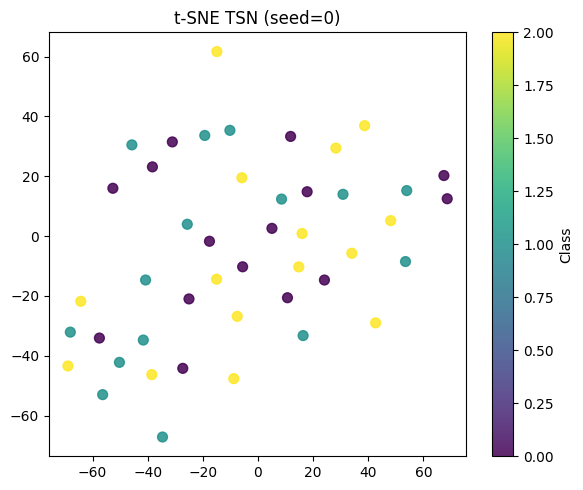

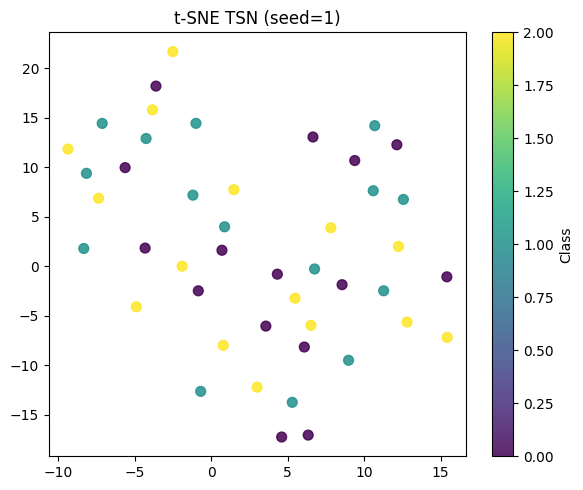

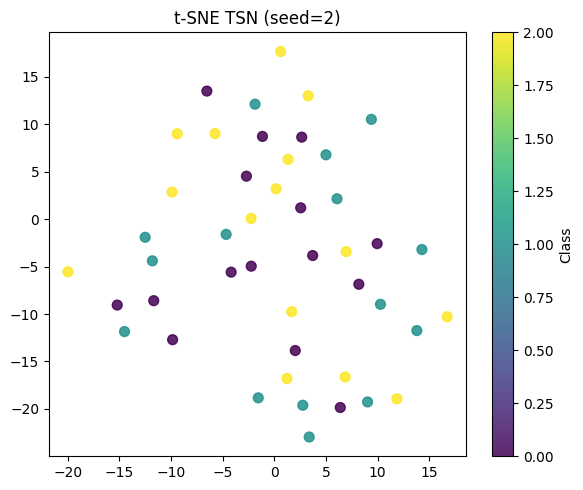

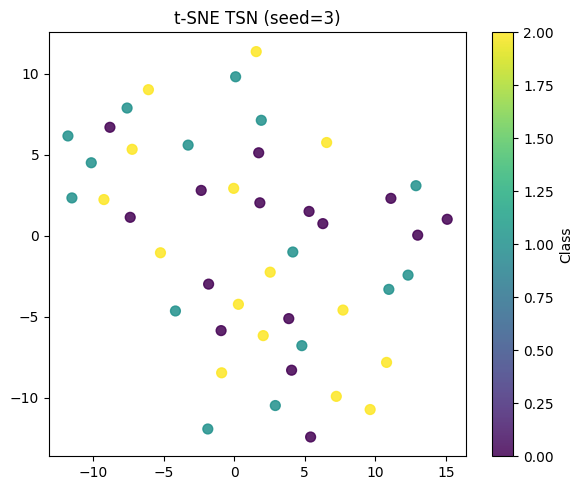

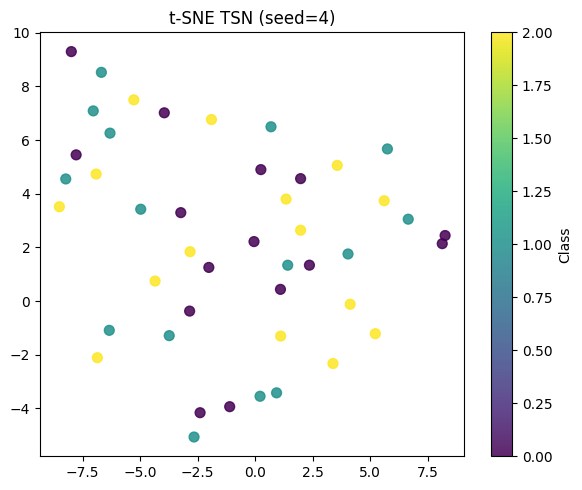

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = torch.cat([X_tr, X_va, X_te], dim=0).cpu().numpy()
y = torch.cat([y_tr, y_va, y_te], dim=0).cpu().numpy()


# standardizza
Xz = StandardScaler().fit_transform(X)

# PCA
Xp = PCA(n_components=min(30, Xz.shape[1]), random_state=0).fit_transform(Xz)

# t-SNE con più seed
for seed in [0,1,2,3,4]:
    tsne = TSNE(
        n_components=2,
        perplexity=10,
        init="pca",
        learning_rate="auto",
        random_state=seed
    )
    X2 = tsne.fit_transform(Xp)

    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=50, alpha=0.85)
    plt.title(f"t-SNE TSN (seed={seed})")
    plt.colorbar(label="Class")
    plt.tight_layout()
    plt.show()



Visualizza in 2D le feature EEGPT a livello di finestre (window-level), non a livello di registrazioni.

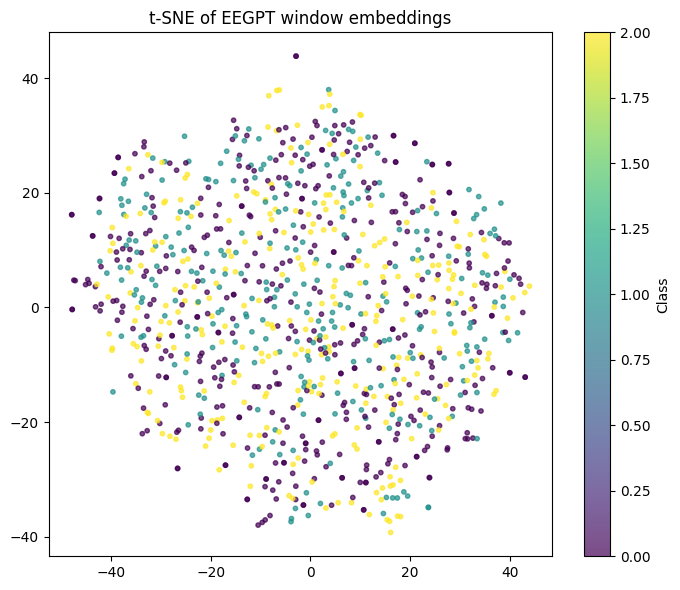

In [ ]:
import torch, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = torch.load("eegpt_window_features_fold0.pt", map_location="cpu", weights_only=False)

Xw = data["tr_feat"].numpy()   # (Nwin, D)  oppure concatena tr+va+te
yw = data["tr_y"].numpy()

# (opzionale) subsample per velocità
idx = np.random.RandomState(0).choice(len(Xw), size=min(2000, len(Xw)), replace=False)
Xw = Xw[idx]
yw = yw[idx]

Xz = StandardScaler().fit_transform(Xw)
Xp = PCA(n_components=30, random_state=0).fit_transform(Xz)

tsne = TSNE(
    n_components=2,
    perplexity=30,     # con 2000 punti 20-50 ok
    init="pca",
    learning_rate="auto",
    random_state=0
)
X2 = tsne.fit_transform(Xp)

plt.figure(figsize=(7,6))
plt.scatter(X2[:,0], X2[:,1], c=yw, s=10, alpha=0.7)
plt.title("t-SNE of EEGPT window embeddings")
plt.colorbar(label="Class")
plt.tight_layout()
plt.show()


# cambiamenti
- 128 patch size vuol dire che dati 4 s si hanno 1024/128 = 8 campioni invece degli attuali 64 patch size che sarebbe 1024/64=16 campioni
- in task dividere aithmetic e stroops
- cambiare dataset
